What if we just used the forward model to get exchange between substrate pools and calculate the probabilities based on the proportions of substrate? Like what's the probability of getting a 15NH2OH and a 15NO? Then we can add these to get the total production of 46N2O that we would expect from that combination of processes — and attribute any extra to a different, missing process?

If the hybrid process is drawing equally on the NH4+ and NO2- pools, should we calculate the total rate not as the sum of rate constants times substrates, but rather as a minimum of whichever substrate is the limiting reagent?


In [183]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# use for plotting interpolations of measured incubation data
import scipy.interpolate as interp

# use for nelder-mead optimization of a convex function
from scipy.optimize import minimize
from numpy.random import rand

import scripts as sc # Python scripts containing helper functions

Test modules:

In [169]:
?sc.IsotopeEffects

In [184]:
NH4_ambient = 50.0 # nmol/L
d15NH4_ambient = 7.0 # per mil, assume
__, _, af = sc.convert_delta(NH4_ambient, d15NH4_ambient)
print(af)

0.0036885495224455744


In [185]:
af_spike = 0.999
_, d15N_spike = sc.convert_af(af_spike)
print(d15N_spike)

271727043.47646296


In [186]:
print(sc.binomial(0.99, 0.40))

(0.396, 0.594, 0.0040000000000000036, 0.006000000000000005)


In [187]:
sc.grid_data(filename='00_incubationdata.csv',
                          station="PS2", feature="SCM", tracer="NO2-", 
                          T=1000)

,Incubation_time_hrs,44N2O,45N2Oa,45N2Ob,46N2O,x,timepoint,adjusted_timepoint
0,0.283333,17.287897,0.079703,0.067088,0.038824,11.805556,12.0,0.0
1,11.733333,17.300354,0.151967,0.060203,0.074242,488.888889,489.0,477.0
2,24.083333,17.855326,0.183157,0.055270,0.103027,1003.472222,1003.0,991.0


Set up the model:

In [188]:
### READ IN TRAINING DATA ###
PS2SCM15NO2 = sc.grid_data(filename='00_incubationdata.csv',
                          station="PS2", feature="SCM", tracer="NO2-", 
                          T=1000)

In [189]:
### INITS ###

### STATION SPECIFIC ###

"""
Station: PS2
Feature: Secondary chlorophyll max
Tracer: 15NO2-
"""

N2O44_init, N2O45a_init, N2O45b_init, N2O46_init = sc.initialize_n2o(trainingdata = PS2SCM15NO2)

NH4_ambient = 50.0 # nmol/L
NO2_ambient = 0.027885*1000 #nmol/L
NO3_ambient = 28.101655*1000 # nmol/L

d15NH4_ambient = 7.0 # per mil, assume
d15NO2_ambient = -22.82 # per mil, PS2 sigma-theta=26.27
d15NO3_ambient = 15.25 # per mil, PS2 sigma-theta=26.27

__, _, afNH4_ambient = sc.convert_delta(NH4_ambient, d15NH4_ambient)
__, _, afNO2_ambient = sc.convert_delta(NO2_ambient, d15NO2_ambient)
__, _, afNO3_ambient = sc.convert_delta(NO3_ambient, d15NO3_ambient)

### NON-STATION SPECIFIC ###

NH4_carrier = 0.50*1000 # nmol/L; THESE ARE TRUE FOR ALL EXPERIMENTS
NO2_carrier = 1.00*1000 # nmol/L
NO3_carrier = 0.0 # nmol/L

R15std = 0.00367647 # air N2
af_carrier = R15std/(1+R15std)

NH4_spike = 0.50*1000 # nmol/L; THESE ARE TRUE FOR ALL EXPERIMENTS
NO2_spike = 4.80*1000 # nmol/L
NO3_spike = 1.00*1000 # nmol/L

af_spike = 0.99999999
_, d15N_spike = sc.convert_af(af_spike)

### ISOTOPE MIXING - TRACER ###

NO2_init = NO2_ambient + NO2_spike # nmol/L
AFNO2_init = (afNO2_ambient*NO2_ambient + af_spike*NO2_spike)/NO2_init
_, d15NO2_init = sc.convert_af(AFNO2_init)

### ISOTOPE MIXING - NATURAL ABUNDANCE SPECIES ###

NH4_init = NH4_ambient + NH4_carrier # nmol/L
AFNH4_init = (afNH4_ambient*NH4_ambient + af_carrier*NH4_carrier)/NH4_init
_, d15NH4_init = sc.convert_af(AFNH4_init)

NO3_init = NO3_ambient + NO3_carrier # nmol/L
AFNO3_init = (afNO3_ambient*NO3_ambient + af_carrier*NO3_carrier)/NO3_init
_, d15NO3_init = sc.convert_af(AFNO3_init)

### NON-MEASURED SPECIES ###

NO_init = 0.0 # assume that NO starts at 0
d15NO_init = 0.0

NH2OH_init = 0.0 # assume that NH2OH starts at 0
d15NH2OH_init = 0.0

N2_init = 0.0 # assume that N2 starts at 0
d15NO_init = 0.0

In [190]:
### ISOTOPE EFFECTS ###
isos = sc.IsotopeEffects()

In [191]:
### INITIALIZE MODEL PARAMETERS ###

# time step (d)
dt = 0.001 # 0.001 days/timestep or 1,000 timesteps/day
#dt = 0.2 # 0.2 days/timestep or 5 timesteps/day

# number of timesteps (y)
# increasing n(timesteps) by a factor of 10 decreases rate constants by the same factor
T = 1000 # this gets us up to timestep 999
times = np.array(list(range(1,T+1))) # vector of timesteps

### INITIALIZE STATE VARIABLES ###

# N2O state variables
n2o_44_i = N2O44_init
n2o_45a_i = N2O45a_init
n2o_45b_i = N2O45b_init
n2o_46_i = N2O46_init
#n2o_16_i = 0.5*n2o_44_i # 2 nitrogen atoms per oxygen!
#n2o_18_i = R18n2o_i*n2o_16_i

# substrate state variables
nh4_14_i, nh4_15_i, _ = sc.convert_delta(concentration=NH4_init, d15N=d15NH4_init)
no2_14_i, no2_15_i, _ = sc.convert_delta(concentration=NO2_init, d15N=d15NO2_init)
no3_14_i, no3_15_i, _ = sc.convert_delta(concentration=NO3_init, d15N=d15NO3_init)

# initialize arrays of state variables
n2o_44 = np.zeros(shape = (T,1))
n2o_45a = np.zeros(shape = (T,1))
n2o_45b = np.zeros(shape = (T,1))
n2o_46 = np.zeros(shape = (T,1))
nh4_14 = np.zeros(shape = (T,1))
nh4_15 = np.zeros(shape = (T,1))
no2_14 = np.zeros(shape = (T,1))
no2_15 = np.zeros(shape = (T,1))
no3_14 = np.zeros(shape = (T,1))
no3_15 = np.zeros(shape = (T,1))
n2_28 = np.zeros(shape = (T,1))
n2_29 = np.zeros(shape = (T,1))
n2_30 = np.zeros(shape = (T,1))

afnh4 = np.zeros(shape = (T,1))
afno2 = np.zeros(shape = (T,1))
afno3 = np.zeros(shape = (T,1))

# initial values of state variables
n2o_44[0,:] = n2o_44_i
n2o_45a[0,:] = n2o_45a_i
n2o_45b[0,:] = n2o_45b_i
n2o_46[0,:] = n2o_46_i
nh4_14[0,:] = nh4_14_i
nh4_15[0,:] = nh4_15_i
no2_14[0,:] = no2_14_i
no2_15[0,:] = no2_15_i
no3_14[0,:] = no3_14_i
no3_15[0,:] = no3_15_i
n2_28[0,:] = 0
n2_29[0,:] = 0
n2_30[0,:] = 0

afnh4[0,:] = nh4_15_i/(nh4_14_i+nh4_15_i)
afno2[0,:] = no2_15_i/(no2_14_i+no2_15_i)
afno3[0,:] = no3_15_i/(no3_14_i+no3_15_i) 

### ISOTOPE CONSTANTS ###
R15std = 0.00367647 # air N2
R18std = 0.00200517 # VSMOW

In [192]:
### RATE CONSTANTS ###

### SUBSTRATE EXCHANGE ###

kNH4TONO2 = 0.539726351/(NH4_ambient + NH4_spike)
kNO2TONO3 = 73.23197829/(NO2_ambient + NO2_spike)
kNO3TONO2 = 25.74033006/(NO3_ambient + NO3_spike)

kNH4toNH2OH = kNH4TONO2
kNH2OHtoNO = kNH4TONO2

### MEASURED RATES OF N2O PRODUCTION ###

kNO2TON2Oa = 0.112/(NO2_spike) # these are the rates measured in the 15NO2- experiment
kNO2TON2Ob = 0.000/(NO2_spike)
kNO2TO46N2O = 0.067/(NO2_spike)

kNO3TON2Oa = 0.019/(NO3_spike) # these are the rates measured in the 15NO3- experiment
kNO3TON2Ob = 0.017/(NO3_spike)
kNO3TO46N2O = 0.004/(NO3_spike)

kNH4TON2Oa = 0.000/(NH4_spike) # these are the rates measured in the 15NH4+ experiment
kNH4TON2Ob = 0.003/(NH4_spike)
kNH4TO46N2O = 0.000/(NH4_spike)

### ASSUMED RATES OF N2O PRODUCTION ###

knitrification = 0.003/(NH4_spike + NH4_ambient)
kdenitno2 = 0.067/(NO2_spike + NO2_ambient)/(0.994245**2)
kdenitno3 = 0.0015/(NO3_spike + NO3_ambient)/(0.034362**2)
khybrid = 4.31930070e-08
khybrid2 = 2.08974412e-09

### N2O CONSUMPTION ###

kN2OCONS = 0.056 # /day

x = [knitrification, kdenitno2, kdenitno3, khybrid]

# not used if we're using the limiting reagent idea:
khybridnh4 = 0.003/(NH4_spike + NH4_ambient)
khybridno2 = 0.112/(NO2_spike + NO2_ambient)

In [193]:
def objective(x):

    ### UNPACK X ###
    [knitrification, kdenitno2, kdenitno3, khybrid] = x

    ### TIME STEPPING ###
    for iT in range(T-1):

        Jhybrid = khybrid*(nh4_14[iT]+nh4_15[iT])*(no2_14[iT]+no2_15[iT])

        # update substrate values
        nh4_14[iT+1,:] = nh4_14[iT,:] + dt*(
            -kNH4TONO2*nh4_14[iT]

            -knitrification*nh4_14[iT]
            -Jhybrid/(no2_14[iT]+no2_15[iT])*(1-afnh4[iT,:]))

        nh4_15[iT+1,:] = nh4_15[iT,:] + dt*(
            -kNH4TONO2/isos.alpha15NH4TONO2*nh4_15[iT]

            -knitrification*nh4_15[iT]
            -Jhybrid/(no2_14[iT]+no2_15[iT])*afnh4[iT,:])

        afnh4[iT+1,:] = nh4_15[iT+1,:]/(nh4_14[iT+1,:] + nh4_15[iT+1,:])

        no2_14[iT+1,:] = no2_14[iT,:] + dt*(
            kNH4TONO2*nh4_14[iT]
            +kNO3TONO2*no3_14[iT]
            -kNO2TONO3*no2_14[iT]

            -kdenitno2*no2_14[iT]
            -Jhybrid/(nh4_14[iT]+nh4_15[iT])*(1-afno2[iT,:]))

        no2_15[iT+1,:] = no2_15[iT,:] + dt*(
            kNH4TONO2/isos.alpha15NH4TONO2*nh4_15[iT]
            +kNO3TONO2/isos.alpha15NO3TONO2*no3_15[iT]
            -kNO2TONO3/isos.alpha15NO2TONO3*no2_15[iT]

            -kdenitno2*no2_15[iT]
            -Jhybrid/(nh4_14[iT]+nh4_15[iT])*afno2[iT,:])

        no3_14[iT+1,:] = no3_14[iT,:] + dt*(
            kNO2TONO3*no2_14[iT]
            -kNO3TONO2*no3_14[iT]

            -kdenitno3*no3_14[iT])

        no3_15[iT+1,:] = no3_15[iT,:] + dt*(
            kNO2TONO3/isos.alpha15NO2TONO3*no2_15[iT]
            -kNO3TONO2/isos.alpha15NO3TONO2*no3_15[iT]

            -kdenitno3*no3_15[iT])

        # recalculate atom fractions at each time step
        afnh4[iT+1,:] = nh4_15[iT+1,:]/(nh4_14[iT+1,:] + nh4_15[iT+1,:])
        afno2[iT+1,:] = no2_15[iT+1,:]/(no2_14[iT+1,:] + no2_15[iT+1,:])
        afno3[iT+1,:] = no3_15[iT+1,:]/(no3_14[iT+1,:] + no3_15[iT+1,:])

        # calculate total rates of N2O production from substrates

        total_nitrification = knitrification*nh4_14[iT] + knitrification*nh4_15[iT]
        total_denit_no2 = (kdenitno2*no2_14[iT] + kdenitno2*no2_15[iT])
        total_denit_no3 = (kdenitno3*no3_14[iT] + kdenitno3*no3_15[iT])

        # calculate probabilities of isotopomer formation
        #p46hybrid, p45ahybrid, p45bhybrid, p44hybrid = sc.binomial(afno2[iT], afnh4[iT])

        p1, p2, p3, p4 = sc.binomial(afno2[iT], afnh4[iT])

        p46hybrid = p1
        p45ahybrid = p2 #(p2+p3)/2
        p45bhybrid =  p3 #(p2+p3)/2
        p44hybrid = p4

        p46nh4, p45anh4, p45bnh4, p44nh4 = sc.binomial(afnh4[iT], afnh4[iT])
        p46no2, p45ano2, p45bno2, p44no2 = sc.binomial(afno2[iT], afno2[iT])
        p46no3, p45ano3, p45bno3, p44no3 = sc.binomial(afno3[iT], afno3[iT])

        # update N2O values
        n2o_46[iT+1,:] = n2o_46[iT,:] + dt*(
            +Jhybrid*p46hybrid
            +total_nitrification*p46nh4
            +total_denit_no2*p46no2
            +total_denit_no3*p46no3
            -kN2OCONS/isos.alpha46N2OtoN2*n2o_46[iT])

        n2o_45a[iT+1, :] = n2o_45a[iT,:] + dt*(
            +Jhybrid*p45ahybrid
            +total_nitrification*p45anh4
            +total_denit_no2*p45ano2
            +total_denit_no3*p45ano3
            -kN2OCONS/isos.alpha15N2OatoN2*n2o_45a[iT])

        n2o_45b[iT+1, :] = n2o_45b[iT,:] + dt*(
            +Jhybrid*p45bhybrid
            +total_nitrification*p45bnh4
            +total_denit_no2*p45bno2
            +total_denit_no3*p45bno3
            -kN2OCONS/isos.alpha15N2ObtoN2*n2o_45b[iT])

        n2o_44[iT+1,:] = n2o_44[iT,:] + dt*(
            +Jhybrid*p44hybrid
            +total_nitrification*p44nh4
            +total_denit_no2*p44no2
            +total_denit_no3*p44no3
            -kN2OCONS*n2o_44[iT])

        # update N2 values

        n2_28[iT+1,:] = n2_28[iT,:] + dt*(kN2OCONS*n2o_44[iT])

        n2_29[iT+1,:] = n2_29[iT,:] + dt*(
            kN2OCONS/isos.alpha15N2OatoN2*n2o_45a[iT]
            +kN2OCONS/isos.alpha15N2ObtoN2*n2o_45b[iT])

        n2_30[iT+1,:] = n2_30[iT,:] + dt*(kN2OCONS/isos.alpha46N2OtoN2*n2o_46[iT])

    #calculate cost
    cost = sc.costfxn(trainingdata = PS2SCM15NO2,
                    modeled_44 = n2o_44,
                    modeled_45a = n2o_45a,
                    modeled_45b = n2o_45b,
                    modeled_46 = n2o_46,
                    weights = np.array([1,10,10,10]))
    return cost

In [194]:
objective(x)

0.43772031976045456

## Optimization

In [142]:
xguess = x

xguess

[5.4545454545454545e-06,
 1.4038834516023652e-05,
 4.365326222148427e-05,
 2.08974412e-09]

In [22]:
### OPTIMIZE WITH RANDOMLY SELECTED X0 ###

# define range for input
r_min, r_max = 0.0, 0.0005
# define the starting point as a random sample from the domain
pt = r_min + rand(4) * (r_max - r_min)

pt

array([0.00018133, 0.00019808, 0.00018411, 0.00021888])

In [143]:
# define bounds: no negative rate constants
bnds = ((0, None), (0, None), (0, None), (0, None))

# perform the search with randomly selected x0
result = minimize(objective, pt, method='nelder-mead', bounds=bnds)
# summarize the result
print('Status : %s' % result['message'])
print('Total Evaluations: %d' % result['nfev'])
# evaluate solution
solution = result['x']
evaluation = objective(solution)
print('Solution: f(%s) = %.5f' % (solution, evaluation))

NameError: name 'pt' is not defined

In [195]:
# define bounds: no negative rate constants
bnds = ((0, None), (0, None), (0, None), (0, None))

# perform the search with intelligently selcted x0
result = minimize(objective, xguess, method='nelder-mead', bounds=bnds)
# summarize the result
print('Status : %s' % result['message'])
print('Total Evaluations: %d' % result['nfev'])
# evaluate solution
solution = result['x']
evaluation = objective(solution)
print('Solution: f(%s) = %.5f' % (solution, evaluation))

Status : Optimization terminated successfully.
Total Evaluations: 151
Solution: f([0.00000000e+00 1.48040437e-05 5.14321321e-05 4.31930070e-08]) = 0.37514


In [196]:
objective(result.x)

0.37513693741358073

In [197]:
result.x

array([0.00000000e+00, 1.48040437e-05, 5.14321321e-05, 4.31930070e-08])

In [198]:
x = result.x

### UNPACK X ###
[knitrification, kdenitno2, kdenitno3, khybrid] = x

### TIME STEPPING ###
for iT in range(T-1):

    Jhybrid = khybrid*(nh4_14[iT]+nh4_15[iT])*(no2_14[iT]+no2_15[iT])

    # update substrate values
    nh4_14[iT+1,:] = nh4_14[iT,:] + dt*(
        -kNH4TONO2*nh4_14[iT]

        -knitrification*nh4_14[iT]
        -Jhybrid/(no2_14[iT]+no2_15[iT])*(1-afnh4[iT,:]))

    nh4_15[iT+1,:] = nh4_15[iT,:] + dt*(
        -kNH4TONO2/isos.alpha15NH4TONO2*nh4_15[iT]

        -knitrification*nh4_15[iT]
        -Jhybrid/(no2_14[iT]+no2_15[iT])*afnh4[iT,:])

    afnh4[iT+1,:] = nh4_15[iT+1,:]/(nh4_14[iT+1,:] + nh4_15[iT+1,:])

    no2_14[iT+1,:] = no2_14[iT,:] + dt*(
        kNH4TONO2*nh4_14[iT]
        +kNO3TONO2*no3_14[iT]
        -kNO2TONO3*no2_14[iT]

        -kdenitno2*no2_14[iT]
        -Jhybrid/(nh4_14[iT]+nh4_15[iT])*(1-afno2[iT,:]))

    no2_15[iT+1,:] = no2_15[iT,:] + dt*(
        kNH4TONO2/isos.alpha15NH4TONO2*nh4_15[iT]
        +kNO3TONO2/isos.alpha15NO3TONO2*no3_15[iT]
        -kNO2TONO3/isos.alpha15NO2TONO3*no2_15[iT]

        -kdenitno2*no2_15[iT]
        -Jhybrid/(nh4_14[iT]+nh4_15[iT])*afno2[iT,:])

    no3_14[iT+1,:] = no3_14[iT,:] + dt*(
        kNO2TONO3*no2_14[iT]
        -kNO3TONO2*no3_14[iT]

        -kdenitno3*no3_14[iT])

    no3_15[iT+1,:] = no3_15[iT,:] + dt*(
        kNO2TONO3/isos.alpha15NO2TONO3*no2_15[iT]
        -kNO3TONO2/isos.alpha15NO3TONO2*no3_15[iT]

        -kdenitno3*no3_15[iT])

    # recalculate atom fractions at each time step
    afnh4[iT+1,:] = nh4_15[iT+1,:]/(nh4_14[iT+1,:] + nh4_15[iT+1,:])
    afno2[iT+1,:] = no2_15[iT+1,:]/(no2_14[iT+1,:] + no2_15[iT+1,:])
    afno3[iT+1,:] = no3_15[iT+1,:]/(no3_14[iT+1,:] + no3_15[iT+1,:])

    # calculate total rates of N2O production from substrates

    total_nitrification = knitrification*nh4_14[iT] + knitrification*nh4_15[iT]
    total_denit_no2 = (kdenitno2*no2_14[iT] + kdenitno2*no2_15[iT])
    total_denit_no3 = (kdenitno3*no3_14[iT] + kdenitno3*no3_15[iT])

    # calculate probabilities of isotopomer formation
    #p46hybrid, p45ahybrid, p45bhybrid, p44hybrid = sc.binomial(afno2[iT], afnh4[iT])

    p1, p2, p3, p4 = sc.binomial(afno2[iT], afnh4[iT])

    p46hybrid = p1
    p45ahybrid = p2 #(p2+p3)/2
    p45bhybrid =  p3 #(p2+p3)/2
    p44hybrid = p4

    p46nh4, p45anh4, p45bnh4, p44nh4 = sc.binomial(afnh4[iT], afnh4[iT])
    p46no2, p45ano2, p45bno2, p44no2 = sc.binomial(afno2[iT], afno2[iT])
    p46no3, p45ano3, p45bno3, p44no3 = sc.binomial(afno3[iT], afno3[iT])

    # update N2O values
    n2o_46[iT+1,:] = n2o_46[iT,:] + dt*(
        +Jhybrid*p46hybrid
        +total_nitrification*p46nh4
        +total_denit_no2*p46no2
        +total_denit_no3*p46no3
        -kN2OCONS/isos.alpha46N2OtoN2*n2o_46[iT])

    n2o_45a[iT+1, :] = n2o_45a[iT,:] + dt*(
        +Jhybrid*p45ahybrid
        +total_nitrification*p45anh4
        +total_denit_no2*p45ano2
        +total_denit_no3*p45ano3
        -kN2OCONS/isos.alpha15N2OatoN2*n2o_45a[iT])

    n2o_45b[iT+1, :] = n2o_45b[iT,:] + dt*(
        +Jhybrid*p45bhybrid
        +total_nitrification*p45bnh4
        +total_denit_no2*p45bno2
        +total_denit_no3*p45bno3
        -kN2OCONS/isos.alpha15N2ObtoN2*n2o_45b[iT])

    n2o_44[iT+1,:] = n2o_44[iT,:] + dt*(
        +Jhybrid*p44hybrid
        +total_nitrification*p44nh4
        +total_denit_no2*p44no2
        +total_denit_no3*p44no3
        -kN2OCONS*n2o_44[iT])

    # update N2 values

    n2_28[iT+1,:] = n2_28[iT,:] + dt*(kN2OCONS*n2o_44[iT])

    n2_29[iT+1,:] = n2_29[iT,:] + dt*(
        kN2OCONS/isos.alpha15N2OatoN2*n2o_45a[iT]
        +kN2OCONS/isos.alpha15N2ObtoN2*n2o_45b[iT])

    n2_30[iT+1,:] = n2_30[iT,:] + dt*(kN2OCONS/isos.alpha46N2OtoN2*n2o_46[iT])

#calculate cost
cost = sc.costfxn(trainingdata = PS2SCM15NO2,
                modeled_44 = n2o_44,
                modeled_45a = n2o_45a,
                modeled_45b = n2o_45b,
                modeled_46 = n2o_46,
                weights = np.array([1,10,10,10]))

In [199]:
# one thing that's really useful is that we can pass the "binomial" function full arrays,
# not just single values...

pd.DataFrame(np.array(sc.binomial(afno2, afno2)).reshape(4,1000))

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0.988523,0.988512,0.988502,0.988492,0.988481,0.988471,0.988461,0.988450,0.988440,0.988430,...,0.978269,0.978258,0.978248,0.978238,0.978227,0.978217,0.978207,0.978196,0.978186,0.978176
1,0.005722,0.005727,0.005732,0.005737,0.005743,0.005748,0.005753,0.005758,0.005763,0.005768,...,0.010806,0.010811,0.010816,0.010821,0.010826,0.010832,0.010837,0.010842,0.010847,0.010852
2,0.005722,0.005727,0.005732,0.005737,0.005743,0.005748,0.005753,0.005758,0.005763,0.005768,...,0.010806,0.010811,0.010816,0.010821,0.010826,0.010832,0.010837,0.010842,0.010847,0.010852
3,0.000033,0.000033,0.000033,0.000033,0.000033,0.000033,0.000033,0.000034,0.000034,0.000034,...,0.000119,0.000119,0.000120,0.000120,0.000120,0.000120,0.000120,0.000120,0.000120,0.000120


In [200]:
### CALCULATE OUTPUT ###
nh4_concentration = pd.DataFrame(nh4_14+nh4_15, columns={'[NH4+]_nM'})
d15nh4 = pd.DataFrame((((nh4_15/(nh4_14))/R15std)-1)*1000, columns={'d15NH4+'})
afnh4_df = pd.DataFrame(afnh4, columns={'AFNH4+'})

no3_concentration = pd.DataFrame(no3_14+no3_15, columns={'[NO3-]_nM'})
d15no3 = pd.DataFrame((((no3_15/(no3_14))/R15std)-1)*1000, columns={'d15NO3-'})
afno3_df = pd.DataFrame(afno3, columns={'AFNO3-'})

no2_concentration = pd.DataFrame(no2_14+no2_15, columns={'[NO2-]_nM'})
d15no2 = pd.DataFrame((((no2_15/(no2_14))/R15std)-1)*1000, columns={'d15NO2-'})
afno2_df = pd.DataFrame(afno2, columns={'AFNO2-'})


n2o_concentration = pd.DataFrame(n2o_44+n2o_45a+n2o_45b+n2o_46, columns={'[N2O]_nM'})

n2_concentration = pd.DataFrame(n2_28+n2_29+n2_30, columns = {'[N2]_nM'})


d15Na = pd.DataFrame((((n2o_45a/(n2o_44))/R15std)-1)*1000, columns={'d15N2Oa'})
d15Nb = pd.DataFrame((((n2o_45b/(n2o_44))/R15std)-1)*1000, columns={'d15N2Ob'})
d18O = pd.DataFrame((((n2o_46/(n2o_44))/R15std)-1)*1000, columns={'d18O'})

n2o_44 = pd.DataFrame(n2o_44, columns={'[N2O_44]_nM'})
n2o_45a = pd.DataFrame(n2o_45a, columns={'[N2O_45a]_nM'})
n2o_45b = pd.DataFrame(n2o_45b, columns={'[N2O_45b]_nM'})
n2o_46 = pd.DataFrame(n2o_46, columns={'[N2O_46]_nM'})

output = nh4_concentration.join([
    d15nh4,afnh4_df,
    no3_concentration, d15no3, afno3_df,
    no2_concentration, d15no2, afno2_df,
    n2o_concentration, n2_concentration, n2o_44, n2o_45a, n2o_45b, n2o_46,
    d15Na, d15Nb, d18O])

output["Incubation_time_hrs"] = output.index/1000*24

output['check_mass_conservation'] = output.loc[:,['[NH4+]_nM',
                                                  '[NO3-]_nM',
                                                  '[NO2-]_nM',
                                                  '[N2O]_nM',
                                                  '[N2]_nM',
                                                  '[N2]_nM']].sum(axis=1)
                                                  

In [201]:
output

,[NH4+]_nM,d15NH4+,AFNH4+,[NO3-]_nM,d15NO3-,AFNO3-,[NO2-]_nM,d15NO2-,AFNO2-,[N2O]_nM,[N2]_nM,[N2O_44]_nM,[N2O_45a]_nM,[N2O_45b]_nM,[N2O_46]_nM,d15N2Oa,d15N2Ob,d18O,Incubation_time_hrs,check_mass_conservation
0,550.000000,0.636349,0.003665,28101.655000,15.250000,0.003719,4827.885000,4.698898e+07,0.994245,17.473512,0.000000,17.287897,0.079703,0.067088,0.038824,254.006459,55.539573,-389.164748,0.000,33497.013512
1,549.999460,0.636370,0.003665,28101.703040,15.968136,0.003721,4827.835983,4.694622e+07,0.994240,17.474165,0.000978,17.288364,0.079818,0.067090,0.038893,255.781355,55.542662,-388.096594,0.024,33497.014605
2,549.998921,0.636391,0.003665,28101.751079,16.686262,0.003724,4827.786966,4.690354e+07,0.994234,17.474818,0.001957,17.288831,0.079933,0.067092,0.038962,257.556093,55.545816,-387.028579,0.048,33497.015698
3,549.998381,0.636412,0.003665,28101.799118,17.404377,0.003727,4827.737950,4.686093e+07,0.994229,17.475471,0.002935,17.289298,0.080048,0.067094,0.039031,259.330673,55.549035,-385.960703,0.072,33497.016791
4,549.997841,0.636433,0.003665,28101.847155,18.122482,0.003729,4827.688935,4.681840e+07,0.994224,17.476124,0.003914,17.289765,0.080163,0.067097,0.039099,261.105095,55.552318,-384.892967,0.096,33497.017884
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,549.463253,0.657381,0.003665,28149.058821,724.666254,0.006301,4779.507621,2.456377e+07,0.989048,18.105829,0.991248,17.737828,0.192098,0.071026,0.104877,1945.722636,89.139514,608.236263,23.880,33498.118021
996,549.462714,0.657402,0.003665,28149.106067,725.374091,0.006303,4779.459396,2.455190e+07,0.989043,18.106447,0.992262,17.738265,0.192209,0.071031,0.104941,1947.351717,89.202478,609.176120,23.904,33498.119148
997,549.462174,0.657423,0.003665,28149.153311,726.081918,0.006306,4779.411172,2.454005e+07,0.989038,18.107065,0.993276,17.738703,0.192320,0.071037,0.105005,1948.980661,89.265498,610.115857,23.928,33498.120275
998,549.461635,0.657445,0.003665,28149.200555,726.789735,0.006308,4779.362949,2.452821e+07,0.989033,18.107683,0.994290,17.739140,0.192431,0.071043,0.105069,1950.609470,89.328574,611.055475,23.952,33498.121402


In [202]:
print(output['check_mass_conservation'].min())
print(output['check_mass_conservation'].max())

33497.013511944
33498.12252854001


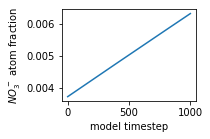

In [203]:
fig, ax = plt.subplots(1,1, figsize = (3,2))

ax.plot(output[['AFNO3-']])
ax.set_xlabel("model timestep")
ax.set_ylabel(r"$NO_3^-$ atom fraction")

plt.tight_layout()
plt.savefig("figures/no3-atomfraction.pdf")

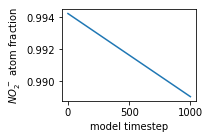

In [204]:
fig, ax = plt.subplots(1,1, figsize = (3,2))

ax.plot(output[['AFNO2-']])
ax.set_xlabel("model timestep")
ax.set_ylabel(r"$NO_2^-$ atom fraction")

plt.tight_layout()
plt.savefig("figures/no2-atomfraction.pdf")

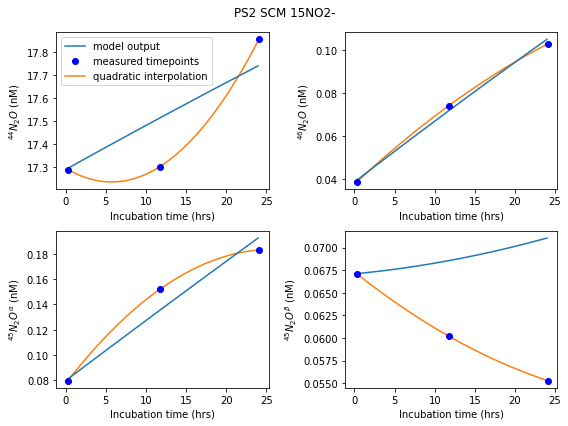

In [205]:
sc.plot_outputs(trainingdata = PS2SCM15NO2, modeloutput=output, 
             filename="Figures/PS2SCM15NO2.pdf")

In [206]:
result.x

array([0.00000000e+00, 1.48040437e-05, 5.14321321e-05, 4.31930070e-08])